In [1]:
import pandas as pd
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib as plt

In [2]:
train = pd.read_csv("/Users/matteoppa/Projectfma/fma/data/fma_metadata/fma_train.csv")

In [3]:
df1 = train.iloc[0:1501]

In [25]:
df1.shape

(1500, 17)

In [26]:
train.shape

(79930, 17)

Here below I'll define a function in order to subsample the dataset: reducing dimensionality will improve execution speed, after subsamling the dataset i will join all the outliers together

In [3]:
def balanced_subsample(x,y,subsample_size=1.0):

    class_xs = []
    min_elems = None

    for yi in np.unique(y):
        elems = x[(y == yi)]
        class_xs.append((yi, elems))
        if min_elems == None or elems.shape[0] < min_elems:
            min_elems = elems.shape[0]

    use_elems = min_elems
    if subsample_size < 1:
        use_elems = int(min_elems*subsample_size)

    xs = []
    ys = []

    for ci,this_xs in class_xs:
        if len(this_xs) > use_elems:
            this_xs = this_xs.reindex(np.random.permutation(this_xs.index))

        x_ = this_xs[:use_elems]
        y_ = np.empty(use_elems)
        y_.fill(ci)

        xs.append(x_)
        ys.append(y_)

    xs = pd.concat(xs)
    ys = pd.Series(data=np.concatenate(ys),name='target')

    return xs,ys

In [4]:
balanced_subsample(train, size= 500)

AttributeError: 'DataFrame' object has no attribute 'value_counts'

In [3]:
db = DBSCAN(eps=10, min_samples= 5)
db.fit(train)

In [ ]:
np.unique(db.labels_, return_counts=True)

LOF algorithm (negative outlier factor)

In [4]:
#LOF
from sklearn.neighbors import LocalOutlierFactor

In [5]:
clf = LocalOutlierFactor(n_neighbors=2)
outliers = clf.fit_predict(train)

In [6]:
clf.negative_outlier_factor_

array([-1.32770421, -1.31223159, -1.62997367, ..., -1.17426119,
       -1.21185295, -0.99018459])

In [7]:
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([11535, 68395]))

In [8]:
np.where(outliers==-1)

(array([    2,    31,    44, ..., 79917, 79925, 79926]),)

In [9]:
clf.negative_outlier_factor_[np.where(outliers==-1)]

array([-1.62997367, -1.82631629, -1.58952511, ..., -1.5765168 ,
       -2.54464209, -1.78380807])

In [10]:
np.max(clf.negative_outlier_factor_[np.where(outliers==-1)])

-1.5000198720456237

In [11]:
np.min(clf.negative_outlier_factor_[np.where(outliers==-1)])

-259336100.58506224

In [13]:
import matplotlib.pyplot as plt

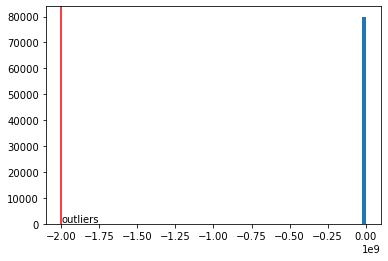

In [14]:
plt.hist(clf.negative_outlier_factor_, bins=10)
plt.axvline(-0.2*1e10, c='r')
plt.text(-0.2*1e10, 600, 'outliers')
plt.show()

PYOD library from here

LOF

In [16]:
from pyod.models.lof import LOF

In [17]:
clf = LOF(n_neighbors=20, algorithm='auto', leaf_size=30, metric='minkowski', p=2, metric_params=None, contamination=0.1, n_jobs=1)
clf.fit(train)

outliers = clf.predict(train)
np.unique(outliers, return_counts=True)

(array([0, 1]), array([72849,  7081]))

Next will be implemented a OCSVM, an outlier classifier based on SVM. As kernel will be used a radial basis function with gamma equals to 1/n_features

In [20]:
from pyod.models.ocsvm import OCSVM

In [21]:
ocsvm = OCSVM(kernel='rbf', degree=3, gamma='auto', coef0=0.0, tol=0.001, nu=0.5, shrinking=True, cache_size=200, verbose=False, max_iter=- 1, contamination=0.1)
ocsvm.fit(train)

OCSVM(cache_size=200, coef0=0.0, contamination=0.1, degree=3, gamma='auto',
   kernel='rbf', max_iter=-1, nu=0.5, shrinking=True, tol=0.001,
   verbose=False)

In [22]:
ocsvm.decision_scores_

array([-522.26880889, 4161.9918289 ,  474.10305004, ..., -535.84194701,
       3053.47587837, -877.16604639])

In [24]:
ocsvm.labels_
np.unique(ocsvm.labels_, return_counts=True) #ritorna due array: il primo con valori 0,1 per outlier/inlier e il secondo con il numero relativo di osservazioni

(array([0, 1]), array([71937,  7993]))

In [25]:
ocsvm.decision_function(train)

array([-522.26880889, 4161.9918289 ,  474.10305004, ..., -535.84194701,
       3053.47587837, -877.16604639])

Implementing SOS, stochastic outlier selection. This algorithm is a probabilistic algorithm that is based on the concept of affinity, an outlier is a point with low affinity with regards to all other points. (HM Janssens, Ferenc Huszár, EO Postma, and HJ van den Herik. Stochastic outlier selection. )

In [4]:
from pyod.models.sos import SOS

In [5]:
sos = SOS(contamination=0.1, perplexity=300, metric='euclidean', eps=1e-05)    #perplexity:A smooth measure of the effective number of neighbours. similar to k in knn. metric any from scipy.spatial_distance
sos.fit(df1)                                                                 #took 53 mins to run with this setup last time

SOS(contamination=0.1, eps=1e-05, metric='euclidean', perplexity=300)

In [31]:
sos.labels_                                         #1 are outlers and 0 inliers (taken from documenatation)
np.unique(sos.labels_, return_counts=True)

(array([0, 1]), array([1350,  150]))

In [8]:
#compute decision score, outliers tend to have a higher value. After computing scores I have an array, I will sort and compute the top 1% of values those will be outliers and I'll have the top 1% of them
sos_scores = sos.decision_scores_
print(sos_scores)

[0.25145077 0.40522657 0.47891759 ... 0.26863885 0.41661939 0.29015413]


In [16]:
score_sorted=np.sort(sos_scores)

In [22]:
np.percentile(score_sorted, 99)
top_ouliers = score_sorted[1485:1499] # I use index in order to visualize top 1% outliers scores as an array
print(top_ouliers)

[0.77529285 0.77746601 0.78022365 0.78786019 0.79603972 0.80190714
 0.80524554 0.8205743  0.82247496 0.82465171 0.83225407 0.83857388
 0.83899578 0.87010374]
